# A TSP GA Example

### Sergio Alberto Mora Pardo, Msc Analytics


Based on "The Project Spot" by Lee Jacobson: http://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5

The Traveling Salesperson Problem (TSP): We have a set of $n$ cities to visit (once each) and we want to do this while minimizing the total distance traveled. As $n$ increases the total number of possible routes grows abruptly: 10 cities implies 10! = 3'628,800, while 30 cities implies 30! = 2.6525E+32. As we've dicussed in class evaluating each of these possible routes is greatly impractical.

The code below provides a tailored implementation of a Genetic Algorithm (GA) for solving the TSP. This code was originally implemented in Java by Lee Jacobson. The original Python translation can be found at https://gist.github.com/turbofart/3428880#file-tsp-py

$\textbf{About the GA}$:

-Each chromosome should represent a feasible route (Tour), i.e., one that does not have repeated genes (cities).

-Mutation and Crossover should be defined accordingly:

 $\textbf{Mutation}$:
 
 One useful type of mutation for this case: SWAP mutation $\rightarrow$ two genes are randomly selected and swaped.

 $\textbf{Crossover}$:
 
 One useful type of crossover for this case: ORDERED crossover $\rightarrow$ we select a subset from the first parent, add it to the offspring and finally add the missing values are then added to the offspring from the second parent in the order they are found.

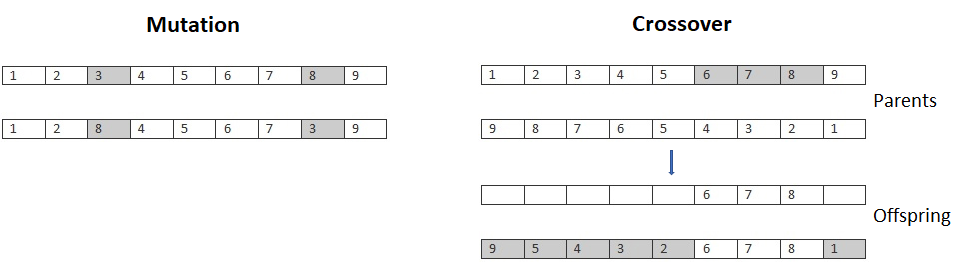

In [1]:
#Import Libraries
import math
import random

In [2]:
#Definition of classes
#This class allows the cities definition

class City:
   def __init__(self, x=None, y=None):
      self.x = None
      self.y = None
      if x is not None:
         self.x = x
      else:
         self.x = int(random.random() * 200)
      if y is not None:
         self.y = y
      else:
         self.y = int(random.random() * 200)
   
   def getX(self):
      return self.x
   
   def getY(self):
      return self.y
   
   def distanceTo(self, city):
      xDistance = abs(self.getX() - city.getX())
      yDistance = abs(self.getY() - city.getY())
      distance = math.sqrt( (xDistance*xDistance) + (yDistance*yDistance) )
      return distance
   
   def __repr__(self):
      return str(self.getX()) + ", " + str(self.getY())

In [3]:
# This class holds all cities in a route (tour)

class TourManager:
   destinationCities = []
   
   def addCity(self, city):
      self.destinationCities.append(city)
   
   def getCity(self, index):
      return self.destinationCities[index]
   
   def numberOfCities(self):
      return len(self.destinationCities)

In [4]:
# Encoding of the routes (tours)

class Tour:
   def __init__(self, tourmanager, tour=None):
      self.tourmanager = tourmanager
      self.tour = []
      self.fitness = 0.0
      self.distance = 0
      if tour is not None:
         self.tour = tour
      else:
         for i in range(0, self.tourmanager.numberOfCities()):
            self.tour.append(None)
   
   def __len__(self):
      return len(self.tour)
   
   def __getitem__(self, index):
      return self.tour[index]
   
   def __setitem__(self, key, value):
      self.tour[key] = value
   
   def __repr__(self):
      geneString = "|"
      for i in range(0, self.tourSize()):
         geneString += str(self.getCity(i)) + "|"
      return geneString
   
   def generateIndividual(self):
      for cityIndex in range(0, self.tourmanager.numberOfCities()):
         self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
      random.shuffle(self.tour)
   
   def getCity(self, tourPosition):
      return self.tour[tourPosition]
   
   def setCity(self, tourPosition, city):
      self.tour[tourPosition] = city
      self.fitness = 0.0
      self.distance = 0
   
   def getFitness(self):
      if self.fitness == 0:
         self.fitness = 1/float(self.getDistance())
      return self.fitness
   
   def getDistance(self):
      if self.distance == 0:
         tourDistance = 0
         for cityIndex in range(0, self.tourSize()):
            fromCity = self.getCity(cityIndex)
            destinationCity = None
            if cityIndex+1 < self.tourSize():
               destinationCity = self.getCity(cityIndex+1)
            else:
               destinationCity = self.getCity(0)
            tourDistance += fromCity.distanceTo(destinationCity)
         self.distance = tourDistance
      return self.distance
   
   def tourSize(self):
      return len(self.tour)
   
   def containsCity(self, city):
      return city in self.tour

In [5]:
# This class holds a population of candidate tours

class Population:
   def __init__(self, tourmanager, populationSize, initialise):
      self.tours = []
      for i in range(0, populationSize):
         self.tours.append(None)
      
      if initialise:
         for i in range(0, populationSize):
            newTour = Tour(tourmanager)
            newTour.generateIndividual()
            self.saveTour(i, newTour)
      
   def __setitem__(self, key, value):
      self.tours[key] = value
   
   def __getitem__(self, index):
      return self.tours[index]
   
   def saveTour(self, index, tour):
      self.tours[index] = tour
   
   def getTour(self, index):
      return self.tours[index]
   
   def getFittest(self):
      fittest = self.tours[0]
      for i in range(0, self.populationSize()):
         if fittest.getFitness() <= self.getTour(i).getFitness():
            fittest = self.getTour(i)
      return fittest
   
   def populationSize(self):
      return len(self.tours)

In [6]:
# This class handles the works of the Genetic Algorithm and evolves the population of solutions

class GA:
   def __init__(self, tourmanager):
      self.tourmanager = tourmanager
      self.mutationRate = 0.015
      self.tournamentSize = 5
      self.elitism = True
   
   def evolvePopulation(self, pop):
      newPopulation = Population(self.tourmanager, pop.populationSize(), False)
      elitismOffset = 0
      if self.elitism:
         newPopulation.saveTour(0, pop.getFittest())
         elitismOffset = 1
      
      for i in range(elitismOffset, newPopulation.populationSize()):
         parent1 = self.tournamentSelection(pop)
         parent2 = self.tournamentSelection(pop)
         child = self.crossover(parent1, parent2)
         newPopulation.saveTour(i, child)
      
      for i in range(elitismOffset, newPopulation.populationSize()):
         self.mutate(newPopulation.getTour(i))
      
      return newPopulation
   
   def crossover(self, parent1, parent2):
      child = Tour(self.tourmanager)
      
      startPos = int(random.random() * parent1.tourSize())
      endPos = int(random.random() * parent1.tourSize())
      
      for i in range(0, child.tourSize()):
         if startPos < endPos and i > startPos and i < endPos:
            child.setCity(i, parent1.getCity(i))
         elif startPos > endPos:
            if not (i < startPos and i > endPos):
               child.setCity(i, parent1.getCity(i))
      
      for i in range(0, parent2.tourSize()):
         if not child.containsCity(parent2.getCity(i)):
            for ii in range(0, child.tourSize()):
               if child.getCity(ii) == None:
                  child.setCity(ii, parent2.getCity(i))
                  break
      
      return child
   
   def mutate(self, tour):
      for tourPos1 in range(0, tour.tourSize()):
         if random.random() < self.mutationRate:
            tourPos2 = int(tour.tourSize() * random.random())
            
            city1 = tour.getCity(tourPos1)
            city2 = tour.getCity(tourPos2)
            
            tour.setCity(tourPos2, city1)
            tour.setCity(tourPos1, city2)
   
   def tournamentSelection(self, pop):
      tournament = Population(self.tourmanager, self.tournamentSize, False)
      for i in range(0, self.tournamentSize):
         randomId = int(random.random() * pop.populationSize())
         tournament.saveTour(i, pop.getTour(randomId))
      fittest = tournament.getFittest()
      return fittest

In [7]:
tourmanager = TourManager()
   
# Create and add our cities
city = City(60, 200)
tourmanager.addCity(city)
city2 = City(180, 200)
tourmanager.addCity(city2)
city3 = City(80, 180)
tourmanager.addCity(city3)
city4 = City(140, 180)
tourmanager.addCity(city4)
city5 = City(20, 160)
tourmanager.addCity(city5)
city6 = City(100, 160)
tourmanager.addCity(city6)
city7 = City(200, 160)
tourmanager.addCity(city7)
city8 = City(140, 140)
tourmanager.addCity(city8)
city9 = City(40, 120)
tourmanager.addCity(city9)
city10 = City(100, 120)
tourmanager.addCity(city10)
city11 = City(180, 100)
tourmanager.addCity(city11)
city12 = City(60, 80)
tourmanager.addCity(city12)
city13 = City(120, 80)
tourmanager.addCity(city13)
city14 = City(180, 60)
tourmanager.addCity(city14)
city15 = City(20, 40)
tourmanager.addCity(city15)
city16 = City(100, 40)
tourmanager.addCity(city16)
city17 = City(200, 40)
tourmanager.addCity(city17)
city18 = City(20, 20)
tourmanager.addCity(city18)
city19 = City(60, 20)
tourmanager.addCity(city19)
city20 = City(160, 20)
tourmanager.addCity(city20)

In [8]:
# Initialize population
pop = Population(tourmanager, 700, True);
print ("Initial distance: " + str(pop.getFittest().getDistance()))

Initial distance: 1582.5299519038008


In [9]:
# Evolve population for 500 generations
ga = GA(tourmanager)
pop = ga.evolvePopulation(pop)
for i in range(0, 1000):
    pop = ga.evolvePopulation(pop)

In [10]:
# Print final results
print ("Finished")
print ("Final distance: " + str(pop.getFittest().getDistance()))
print ("Solution:")
print (pop.getFittest())

Finished
Final distance: 871.117353844847
Solution:
|40, 120|20, 160|60, 200|80, 180|100, 160|100, 120|140, 140|140, 180|180, 200|200, 160|180, 100|180, 60|200, 40|160, 20|120, 80|100, 40|60, 20|20, 20|20, 40|60, 80|


One possible output:

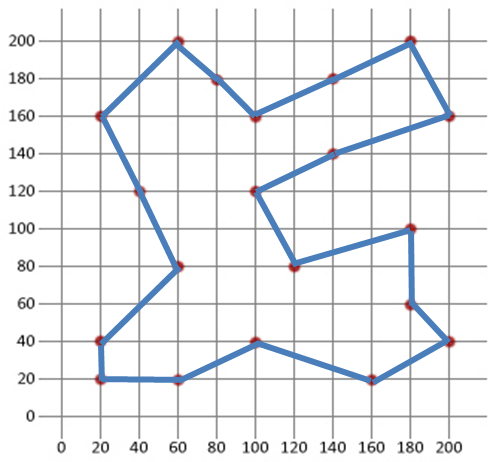
